In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE, f_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import RandomizedLasso, LinearRegression

In [2]:
# read csv file and show head
dataframe = pd.read_csv('kc_house_data.csv')

In [3]:
dataframe.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
# check null values
dataframe.isnull().any()

id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool

In [5]:
# show types of values
dataframe.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [6]:
# delete id and date columns
dataframe = dataframe.drop(['id', 'date'], axis=1)

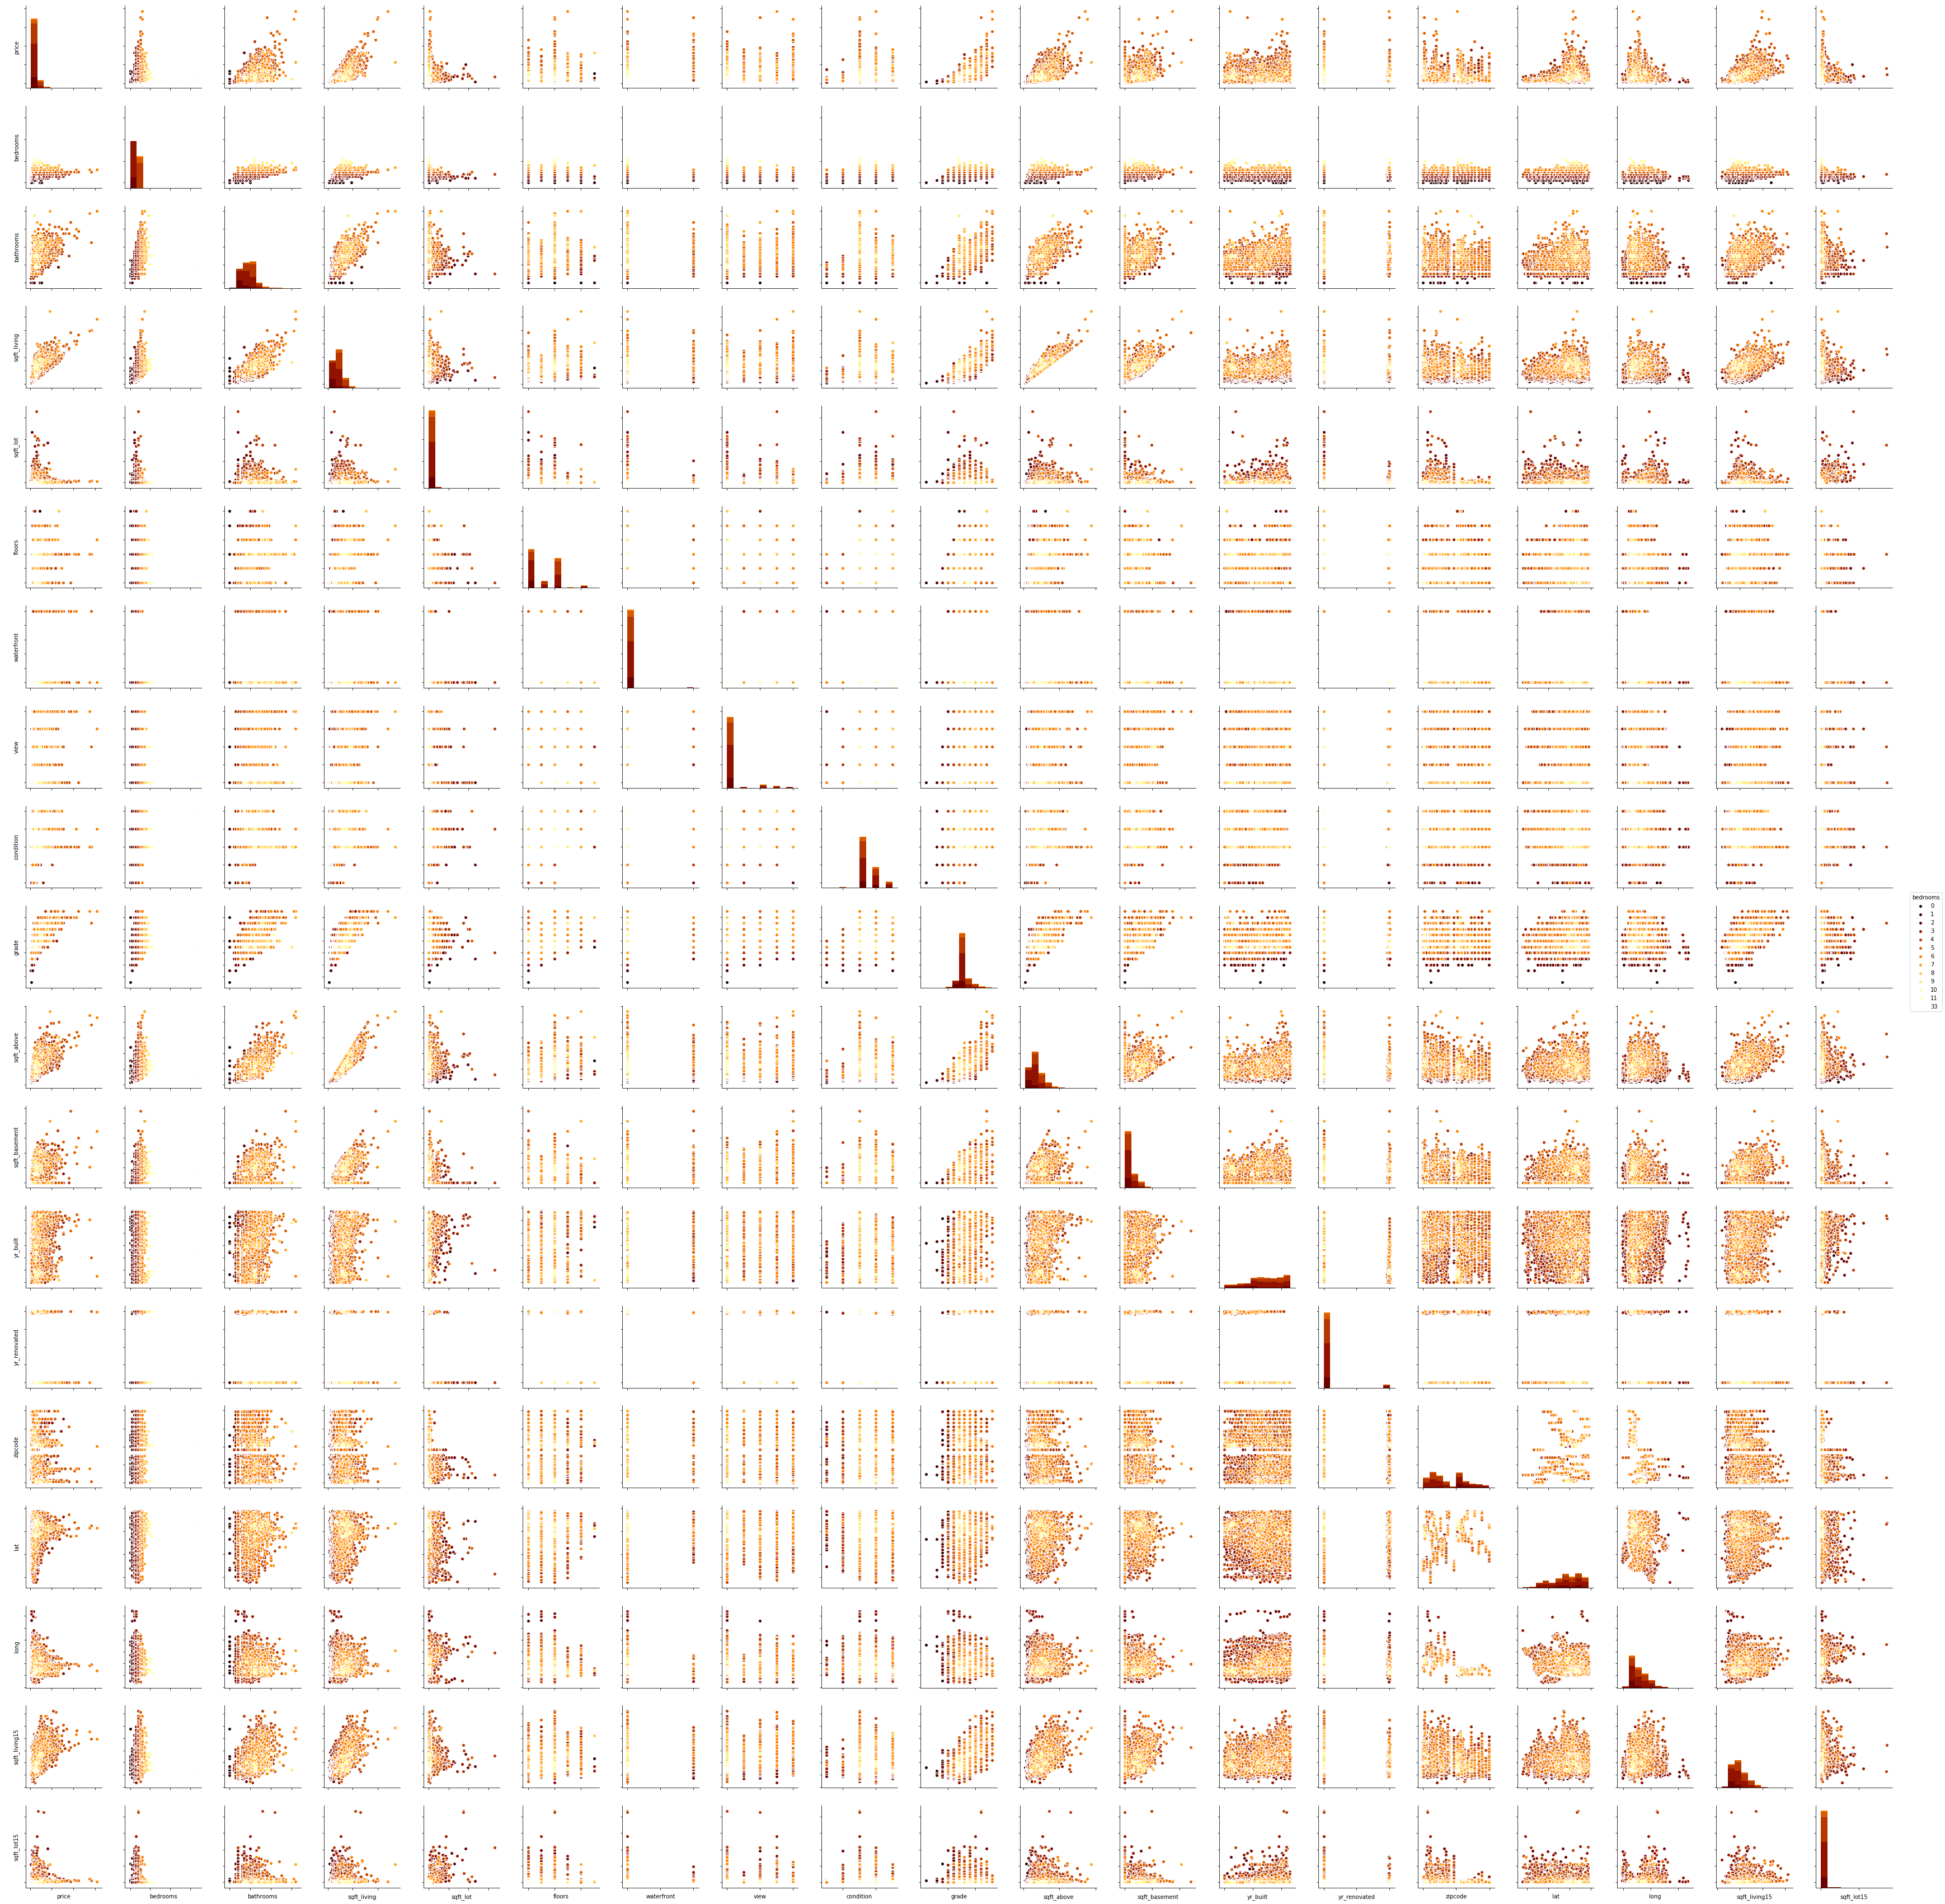

In [7]:
# visualize the data with pairplot
# sns.set(style="ticks", color_codes=True)
g = sns.pairplot(data=dataframe, palette='afmhot', hue='bedrooms')
g.set(xticklabels=[]);
g.set(yticklabels=[]);

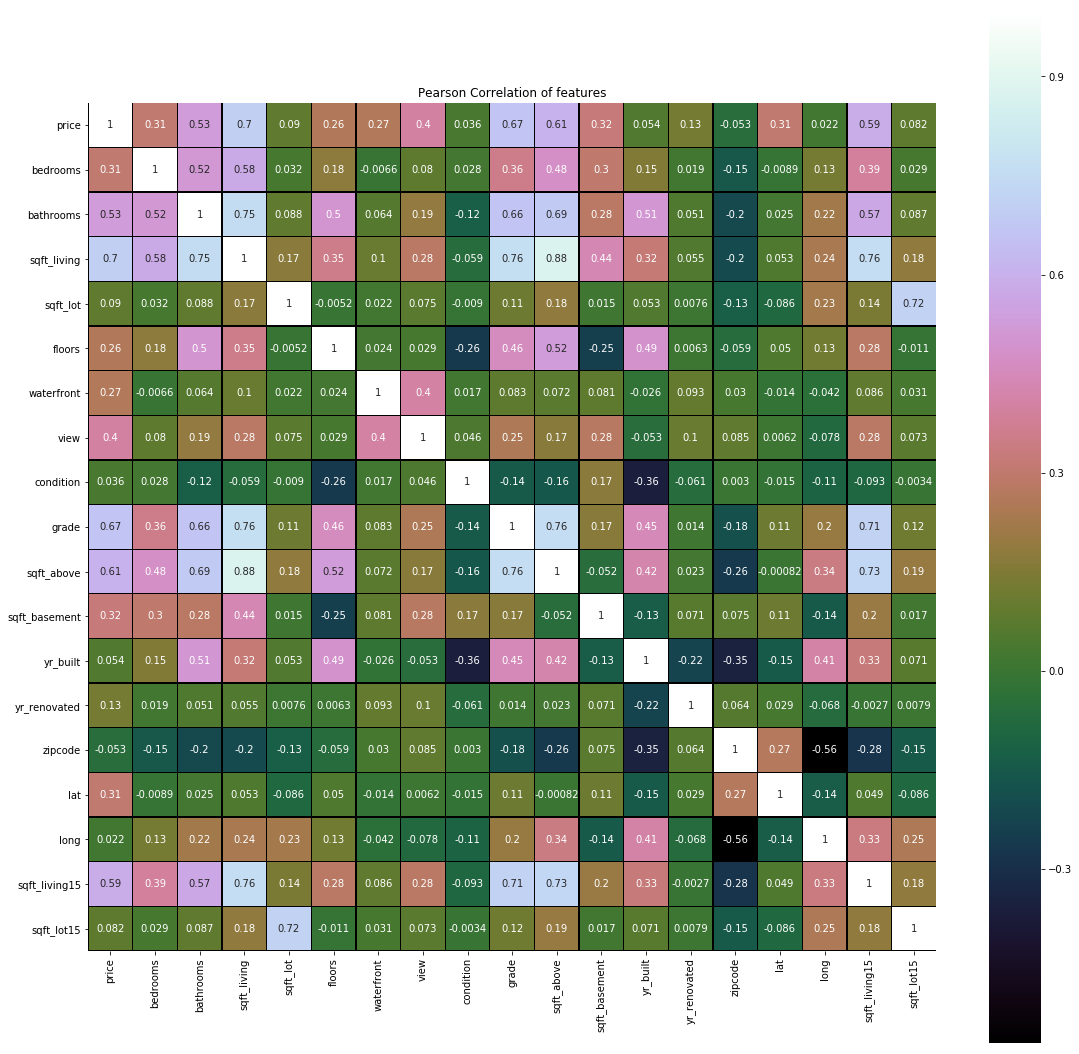

In [8]:
# pearson correlation heatmap
_, _ = plt.subplots(figsize=(19, 19))
plt.title('Pearson Correlation of features')
#sns.heatmap(house_num.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="PuBuGn", linecolor='k', annot=True)
sns.heatmap(
    data=dataframe.astype(float).corr(),
    linewidths=0.25,
    vmax=1.0,
    square=True, 
    cmap="cubehelix",
    linecolor='k',
    annot=True
)

In [7]:
#### Feature Selection ####
# extract the input and target
dataframe_input = dataframe.drop(['price'], axis=1)
X = dataframe_input.as_matrix()
Y = dataframe.price.values

In [8]:
# Define dictionary to store rankings
ranks = {}

In [9]:
# Create function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order * np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [10]:
# Stability Selection method with Randomized Lasso
rand_lasso = RandomizedLasso()
rand_lasso.fit(X, Y)
ranks['rlasso_stability'] = ranking(ranks=np.abs(rand_lasso.scores_), names=dataframe_input.columns)

/media/suno/01D309163D189CB0/PythonProjects/PythonVirtualEnv/ML_py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


In [11]:
# RFE with Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X, Y)
rfe = RFE(estimator=lin_reg, n_features_to_select=1, verbose=3)
rfe.fit(X, Y)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), names=dataframe_input.columns, order=-1)

Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


In [12]:
f, pval = f_regression(X, Y, center=True)
ranks['corr'] = ranking(ranks=f, names=dataframe_input.columns)

In [13]:
# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X, Y)
ranks["lin_reg"] = ranking(ranks=lin_reg.coef_, names=dataframe_input.columns)

In [14]:
# Decision tree Regression
# Fitting Decision Tree Regression to the dataset
tree_reg = DecisionTreeRegressor(random_state = 0)
tree_reg.fit(X, Y)
ranks['tree'] = ranking(ranks=tree_reg.feature_importances_, names=dataframe_input.columns)

In [15]:
means = {}
for feature in dataframe_input.columns:
    means[feature] = np.mean([algo[feature] for algo in ranks.values()])
ranks['mean'] = means

In [16]:
print(" " * 20, "".join(map(lambda k: "%-15s " % k, ranks)))
for feature in sorted(dataframe_input.columns, key=lambda col: ranks['mean'][col], reverse=True):
    print("%-20s" % feature, end='')
    print("".join(map(lambda k: "%-15f " % ranks[k][feature], ranks)))

                     rlasso_stability RFE             corr            lin_reg         tree            mean            
grade               1.000000        0.880000        0.830000        0.380000        1.000000        0.818000        
lat                 1.000000        0.940000        0.110000        1.000000        0.490000        0.708000        
waterfront          1.000000        1.000000        0.080000        0.980000        0.100000        0.632000        
sqft_living         0.650000        0.350000        1.000000        0.260000        0.750000        0.602000        
bathrooms           1.000000        0.710000        0.390000        0.310000        0.010000        0.484000        
view                1.000000        0.760000        0.190000        0.330000        0.020000        0.460000        
sqft_living15       1.000000        0.180000        0.540000        0.260000        0.080000        0.412000        
sqft_above          0.810000        0.290000        0.600000  